### Imports

In [1]:
import torch
import torch.nn as nn

from tqdm.auto import tqdm
import argparse
import os
import random
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision.models.resnet import ResNet, BasicBlock
from typing import Optional, Union, Iterable, Tuple

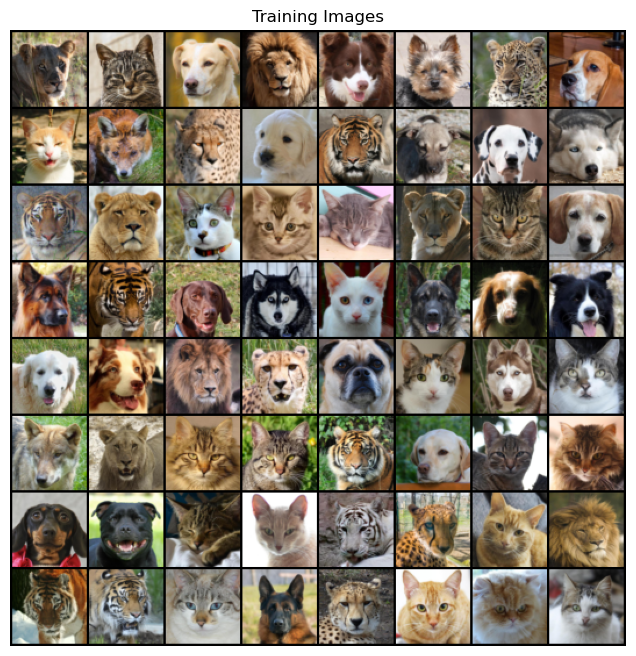

In [2]:

transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = ImageFolder(root="C:\\Users\\Gaurav Talekar\\train", transform=transform)
val_dataset = ImageFolder(root="C:\\Users\\Gaurav Talekar\\val", transform=transform)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=4
)


# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# plt.show()

In [3]:
epochs = 5
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
input_channels = 3
first_fmap_channels = 64
last_fmap_channels = 512 #2048
output_channels = 3
time_embedding = 256
learning_rate = 1e-4 #1e-2
min_lr = 1e-6
weight_decay = 0.0
n_timesteps = 500
beta_min = 1e-4
beta_max = 2e-2
beta_scheduler = 'linear'
batch_size = 128
n_samples = 12_000
cache_size = 12_000
image_size = (64, 64)

In [30]:
class DiffusionUtils:
    def __init__(self, n_timesteps:int, beta_min:float, beta_max:float, device:str='cpu', scheduler:str='linear'):
        assert scheduler in ['linear', 'cosine'], 'scheduler must be linear or cosine'

        self.n_timesteps = n_timesteps
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.device = device
        self.scheduler = scheduler
        
        self.betas = self.betaSamples()
        self.alphas = 1 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)
    
    
    def betaSamples(self):
        if self.scheduler == 'linear':
            return torch.linspace(start=self.beta_min, end=self.beta_max, steps=self.n_timesteps).to(self.device)

        elif self.scheduler == 'cosine':
            betas = []
            for i in reversed(range(self.n_timesteps)):
                T = self.n_timesteps - 1
                beta = self.beta_min + 0.5*(self.beta_max - self.beta_min) * (1 + np.cos((i/T) * np.pi))
                betas.append(beta)
                
            return torch.Tensor(betas).to(self.device)
    
    
    def sampleTimestep(self, size:int):
        #the size argument will let you randomly sample a batch of timesteps
        #output shape: (N, )
        return torch.randint(low=1, high=self.n_timesteps, size=(size, )).to(self.device)
    
    
    def noiseImage(self, x:torch.Tensor, t:torch.LongTensor):
        #expected input is a batch of inputs.
        #image shape: (N, C, H, W)
        #t:torch.Tensor shape: (N, )
        assert len(x.shape) == 4, 'input must be 4 dimensions'
        alpha_hat_sqrts = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        one_mins_alpha_hat_sqrt = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(x).to(self.device)
        return (alpha_hat_sqrts * x) + (one_mins_alpha_hat_sqrt * noise), noise
    
    
    def sample(self, x:torch.Tensor, model:nn.Module, time_iter=0):
        #x shape: (N, C, H, W)
        assert len(x.shape) == 4, 'input must be 4 dimensions'
        model.eval()

        if time_iter==0:
            time_iter = self.n_timesteps


        with torch.no_grad():
            iterations = range(1, time_iter)
            for i in tqdm(reversed(iterations)):
                #batch of timesteps t
                t = (torch.ones(x.shape[0]) * i).long().to(self.device)
                print("t shape is ", t.shape)
                #params
                alpha = self.alphas[t][:, None, None, None]
                beta = self.betas[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                one_minus_alpha = 1 - alpha
                one_minus_alpha_hat = 1 - alpha_hat
                
                #predict noise pertaining for a given timestep
                predicted_noise = model(x, t)
                
                if i > 1:noise = torch.randn_like(x).to(self.device)
                else:noise = torch.zeros_like(x).to(self.device)
                
                x = 1/torch.sqrt(alpha) * (x - ((one_minus_alpha / torch.sqrt(one_minus_alpha_hat)) * predicted_noise))
                x = x + (torch.sqrt(beta) * noise)
                
            return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(3, 64, 64)
min pixel value: 0.0
mean pixel value: 0.14309194684028625
max pixel value: 0.5882353186607361
linear beta scheduling...


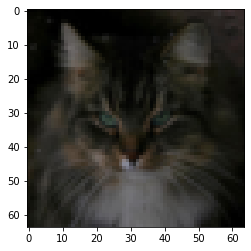

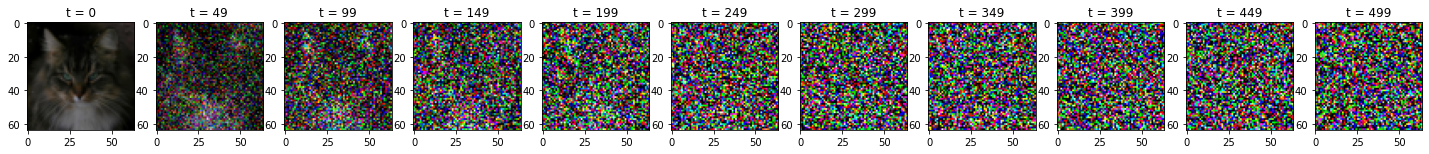

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i



cosine beta scheduling...


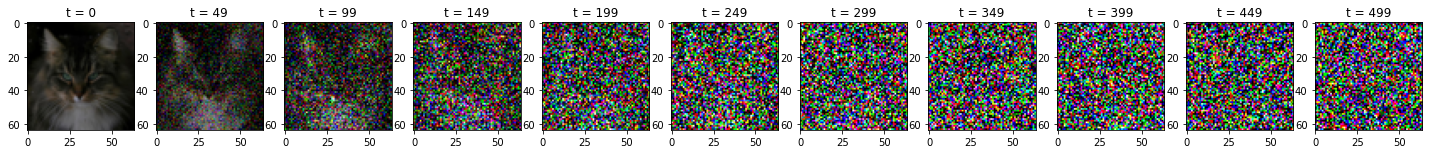

In [28]:
T = n_timesteps
n_steps = 50
alpha_values = {}

sample_img = train_dataset[0][0]
print(sample_img.numpy().shape)

# print(f'shape: {sample_img[0].shape}')
print(f'min pixel value: {sample_img.min()}')
print(f'mean pixel value: {sample_img.mean()}')
print(f'max pixel value: {sample_img.max()}')

plt.imshow(sample_img.permute(1, 2, 0))

for scheduler in ['linear', 'cosine']:
    print(f'{scheduler} beta scheduling...')

    diffusion = DiffusionUtils(T, beta_min, beta_max, scheduler=scheduler)
    alpha_values[scheduler] = diffusion.alphas

    fig, axs = plt.subplots(1, (T//n_steps)+1, figsize=(25, 15))

    axs[0].imshow(sample_img.permute(1, 2, 0))
    axs[0].set_title('t = 0')

    for idx, t in enumerate(range(n_steps-1, T, n_steps)):
        t = torch.Tensor([t]).long()
        x, _ = diffusion.noiseImage(sample_img.unsqueeze(0), t)
        axs[idx+1].imshow(x.squeeze(0).permute(1, 2, 0))
        axs[idx+1].set_title(f't = {t.item()}')
    plt.show()
    print('\n')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

linear beta scheduling...


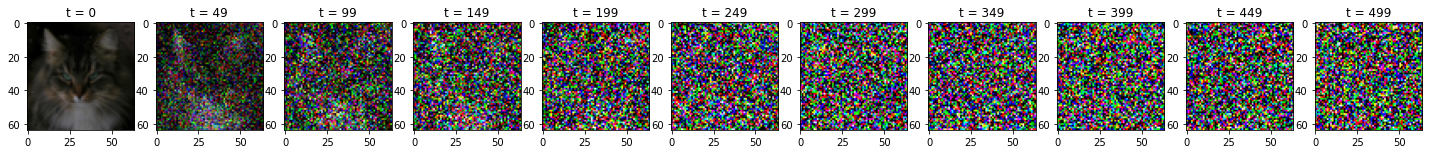

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i



cosine beta scheduling...


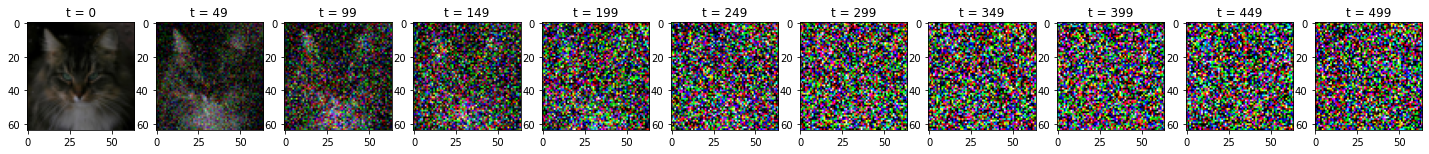

In [6]:
T = n_timesteps
n_steps = 50
alpha_values = {}

for scheduler in ['linear', 'cosine']:
    print(f'{scheduler} beta scheduling...')

    diffusion = DiffusionUtils(T, beta_min, beta_max, scheduler=scheduler)
    alpha_values[scheduler] = diffusion.alphas

    fig, axs = plt.subplots(1, (T//n_steps)+1, figsize=(25, 15))

    axs[0].imshow(sample_img.permute(1, 2, 0))
    axs[0].set_title('t = 0')

    for idx, t in enumerate(range(n_steps-1, T, n_steps)):
        t = torch.Tensor([t]).long()
        x, _ = diffusion.noiseImage(sample_img.unsqueeze(0), t)
        axs[idx+1].imshow(x.squeeze(0).permute(1, 2, 0))
        axs[idx+1].set_title(f't = {t.item()}')
    plt.show()
    print('\n')

Text(0.5, 1.0, 'alpha values of cosine scheduling')

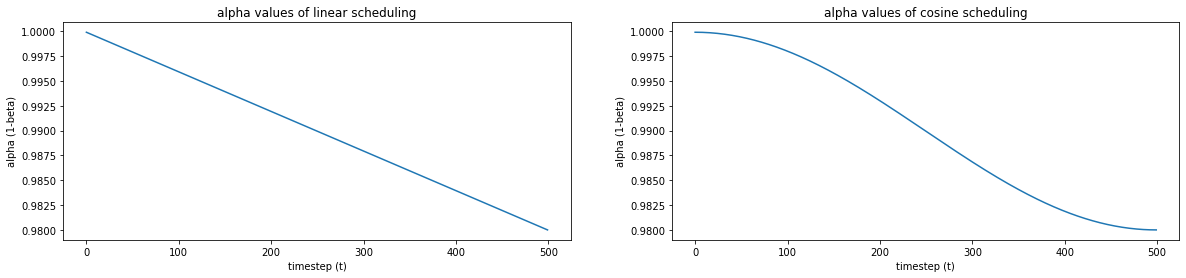

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

axs[0].plot(alpha_values['linear'])
axs[0].set_xlabel('timestep (t)')
axs[0].set_ylabel('alpha (1-beta)')
axs[0].set_title('alpha values of linear scheduling')

axs[1].plot(alpha_values['cosine'])
axs[1].set_xlabel('timestep (t)')
axs[1].set_ylabel('alpha (1-beta)')
axs[1].set_title('alpha values of cosine scheduling')

# Time Embeddings

In [8]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim_size, n:int=10000):
        assert dim_size % 2 == 0, 'dim_size should be an even number'
            
        super(SinusoidalEmbedding, self).__init__()
        
        self.dim_size = dim_size
        self.n = n
        
    def forward(self, x:torch.Tensor):
        N = len(x)
        output = torch.zeros(size=(N, self.dim_size)).to(x.device)
        
        for idx in range(0, N):
            for i in range(0, self.dim_size//2):
                emb = x[idx] / (self.n ** (2*i / self.dim_size))
                output[idx, 2*i] = torch.sin(emb)
                output[idx, (2*i) + 1] = torch.cos(emb)
        
        return output

In [9]:
class ImageSelfAttention(nn.Module):
    def __init__(self, input_channels:int, n_heads:int):
        super(ImageSelfAttention, self).__init__()
        
        self.input_channels = input_channels
        self.n_heads = n_heads
        self.layernorm = nn.LayerNorm(self.input_channels)
        self.attention = nn.MultiheadAttention(self.input_channels, self.n_heads, batch_first=True)
        
    def forward(self, x:torch.Tensor):
        # shape of x: (N, C, H, W)
        _, C, H, W = x.shape
        x = x.reshape(-1, C, H*W).permute(0, 2, 1)
        normalised_x = self.layernorm(x)
        attn_val, _ = self.attention(normalised_x, normalised_x, normalised_x)
        attn_val = attn_val + x
        attn_val = attn_val.permute(0, 2, 1).reshape(-1, C, H, W)
        return attn_val

In [10]:
class Encoder(ResNet):
    def __init__(
        self, input_channels:int, time_embedding:int, 
        block=BasicBlock, block_layers:list=[2, 2, 2, 2], n_heads:int=4):
      
        self.block = block
        self.block_layers = block_layers
        self.time_embedding = time_embedding
        self.input_channels = input_channels
        self.n_heads = n_heads
        
        super(Encoder, self).__init__(self.block, self.block_layers)
        
        #time embedding layer
        self.sinusiodal_embedding = SinusoidalEmbedding(self.time_embedding)
        
        fmap_channels = [64, 64, 128, 256, 512]
        #layers to project time embeddings unto feature maps
        self.time_projection_layers = self.make_time_projections(fmap_channels)
        #attention layers for each feature map
        self.attention_layers = self.make_attention_layers(fmap_channels)
        
        self.conv1 = nn.Conv2d(
            self.input_channels, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), 
            bias=False)
        
        self.conv2 = nn.Conv2d(
            64, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3),
            bias=False)

        #delete unwanted layers
        del self.maxpool, self.fc, self.avgpool
        
        
    def forward(self, x:torch.Tensor, t:torch.Tensor):
        #embed time positions
        t = self.sinusiodal_embedding(t)
        
        #prepare fmap2
        fmap1 = self.conv1(x)
        t_emb = self.time_projection_layers[0](t)
        fmap1 = fmap1 + t_emb[:, :, None, None]
        fmap1 = self.attention_layers[0](fmap1)
        
        x = self.conv2(fmap1)
        x = self.bn1(x)
        x = self.relu(x)
        
        #prepare fmap2
        fmap2 = self.layer1(x)
        t_emb = self.time_projection_layers[1](t)
        fmap2 = fmap2 + t_emb[:, :, None, None]
        fmap2 = self.attention_layers[1](fmap2)
        
        #prepare fmap3
        fmap3 = self.layer2(fmap2)
        t_emb = self.time_projection_layers[2](t)
        fmap3 = fmap3 + t_emb[:, :, None, None]
        fmap3 = self.attention_layers[2](fmap3)
        
        #prepare fmap4
        fmap4 = self.layer3(fmap3)
        t_emb = self.time_projection_layers[3](t)
        fmap4 = fmap4 + t_emb[:, :, None, None]
        fmap4 = self.attention_layers[3](fmap4)
        
        #prepare fmap4
        fmap5 = self.layer4(fmap4)
        t_emb = self.time_projection_layers[4](t)
        fmap5 = fmap5 + t_emb[:, :, None, None]
        fmap5 = self.attention_layers[4](fmap5)
        
        return fmap1, fmap2, fmap3, fmap4, fmap5
    
    
    def make_time_projections(self, fmap_channels:Iterable[int]):
        layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(self.time_embedding, ch)
            ) for ch in fmap_channels ])
        
        return layers
    
    def make_attention_layers(self, fmap_channels:Iterable[int]):
        layers = nn.ModuleList([
            ImageSelfAttention(ch, self.n_heads) for ch in fmap_channels
        ])
        
        return layers

In [11]:
class DecoderBlock(nn.Module):
    def __init__(
        self, input_channels:int, output_channels:int, 
        time_embedding:int, upsample_scale:int=2, activation:nn.Module=nn.ReLU,
        compute_attn:bool=True, n_heads:int=4):
        super(DecoderBlock, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels
        self.upsample_scale = upsample_scale
        self.time_embedding = time_embedding
        self.compute_attn = compute_attn
        self.n_heads = n_heads
        
        #attention layer
        if self.compute_attn:
            self.attention = ImageSelfAttention(self.output_channels, self.n_heads)
        else:self.attention = nn.Identity()
        
        #time embedding layer
        self.sinusiodal_embedding = SinusoidalEmbedding(self.time_embedding)
        
        #time embedding projection layer
        self.time_projection_layer = nn.Sequential(
                nn.SiLU(),
                nn.Linear(self.time_embedding, self.output_channels)
            )

        self.transpose = nn.ConvTranspose2d(
            self.input_channels, self.input_channels, 
            kernel_size=self.upsample_scale, stride=self.upsample_scale)
        
        self.instance_norm1 = nn.InstanceNorm2d(self.transpose.in_channels)

        self.conv = nn.Conv2d(
            self.transpose.out_channels, self.output_channels, kernel_size=3, stride=1, padding=1)
        
        self.instance_norm2 = nn.InstanceNorm2d(self.conv.out_channels)
        
        self.activation = activation()

    
    def forward(self, fmap:torch.Tensor, prev_fmap:Optional[torch.Tensor]=None, t:Optional[torch.Tensor]=None):
        output = self.transpose(fmap)
        output = self.instance_norm1(output)
        output = self.conv(output)
        output = self.instance_norm2(output)
        
        #apply residual connection with previous feature map
        if torch.is_tensor(prev_fmap):
            assert (prev_fmap.shape == output.shape), 'feature maps must be of same shape'
            output = output + prev_fmap
            
        #apply timestep embedding
        if torch.is_tensor(t):
            t = self.sinusiodal_embedding(t)
            t_emb = self.time_projection_layer(t)
            output = output + t_emb[:, :, None, None]
            
            output = self.attention(output)
            
        output = self.activation(output)
        return output

In [12]:
class Decoder(nn.Module):
    def __init__(
        self, last_fmap_channels:int, output_channels:int, 
        time_embedding:int, first_fmap_channels:int=64, n_heads:int=4):
        super(Decoder, self).__init__()
        
        self.last_fmap_channels = last_fmap_channels
        self.output_channels = output_channels
        self.time_embedding = time_embedding
        self.first_fmap_channels = first_fmap_channels
        self.n_heads = n_heads

        self.residual_layers = self.make_layers()

        self.final_layer = DecoderBlock(
            self.residual_layers[-1].input_channels, self.output_channels,
            time_embedding=self.time_embedding, activation=nn.Identity, 
            compute_attn=False, n_heads=self.n_heads)

        #set final layer second instance norm to identity
        self.final_layer.instance_norm2 = nn.Identity()


    def forward(self, *fmaps, t:Optional[torch.Tensor]=None):
        #fmaps(reversed): fmap5, fmap4, fmap3, fmap2, fmap1
        fmaps = [fmap for fmap in reversed(fmaps)]
        ouptut = None
        for idx, m in enumerate(self.residual_layers):
            if idx == 0:
                output = m(fmaps[idx], fmaps[idx+1], t)
                continue
            output = m(output, fmaps[idx+1], t)
        
        # no previous fmap is passed to the final decoder block
        # and no attention is computed
        output = self.final_layer(output)
        return output

      
    def make_layers(self, n:int=4):
        layers = []
        for i in range(n):
            if i == 0: in_ch = self.last_fmap_channels
            else: in_ch = layers[i-1].output_channels

            out_ch = in_ch // 2 if i != (n-1) else self.first_fmap_channels
            layer = DecoderBlock(
                in_ch, out_ch, 
                time_embedding=self.time_embedding,
                compute_attn=True, n_heads=self.n_heads)
            
            layers.append(layer)

        layers = nn.ModuleList(layers)
        return layers

In [13]:
class DiffusionNet(nn.Module):
    def __init__(self, encoder:Encoder, decoder:Decoder):
        
        super(DiffusionNet, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x:torch.Tensor, t:torch.Tensor):
        enc_fmaps = self.encoder(x, t=t)
        segmentation_mask = self.decoder(*enc_fmaps, t=t)
        return segmentation_mask

In [14]:
class TrainingPipeline:
    def __init__(self, model, lossfunc, optimizer, diffusion_utils:DiffusionUtils, 
                 device='cpu', weight_init=True, custom_weight_initializer=None):
        
        self.device = device
        self.model = model.to(self.device)
        self.lossfunc = lossfunc
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.diffusion_utils = diffusion_utils
        self.custom_weight_initializer = custom_weight_initializer
        
        if self.weight_init:
            if self.custom_weight_initializer:
                self.model.apply(self.custom_weight_initializer)
            else:
                self.model.apply(self.xavier_init_weights)
        
    
    def xavier_init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight)
            if torch.is_tensor(m.bias):
                m.bias.data.fill_(0.01)
    
    
    def save_model(self, dirname='./model_params', 
                   filename='DDPM.pth.tar'):
        if not os.path.isdir(dirname):os.mkdir(dirname)
        state_dicts = {
            'network_params':self.model.state_dict(),
            'optimizer_params':self.optimizer.state_dict(),
        }
        return torch.save(state_dicts, os.path.join(dirname, filename))
        

    def train(self, dataloader, verbose=False):
        self.model.train()
        loss = 0
        for idx, (images, labels) in tqdm(enumerate(dataloader)):
            self.model.zero_grad()
            #move images to device
            images = images.to(self.device)
            
            #sample timesteps from timestep sampler
            t = self.diffusion_utils.sampleTimestep(size=images.shape[0])
            
            #apply noise at given timesteps t to to the batch of images
            x_t, noise = self.diffusion_utils.noiseImage(images, t)
            
            #predict noise in noisy image (x_t) for the given timestep
            pred_noise = self.model(x_t, t)

            #compute batch loss
            batch_loss = self.lossfunc(pred_noise, noise)
            
            #backward propagation and optimization
            batch_loss.backward()
            self.optimizer.step()
            loss += batch_loss.item()
            
        loss = loss / (idx + 1)
        if verbose:
            print(f'Training Loss: {loss}')

        return loss

In [15]:
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
np.random.seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [16]:
encoder = Encoder(input_channels, time_embedding, block_layers=[2, 2, 2, 2])
decoder = Decoder(last_fmap_channels, output_channels, time_embedding, first_fmap_channels)
model = DiffusionNet(encoder, decoder)

#diffusion utilities class initialisaion
diffusion_utils = DiffusionUtils(n_timesteps, beta_min, beta_max, device, scheduler=beta_scheduler)

#loss function, optimizer and pipeline initialisation
lossfunc = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
pipeline = TrainingPipeline(model, lossfunc, optimizer, diffusion_utils, device, weight_init=True)

# load pretrained weights if available
checkpoint_path = '/kaggle/input/ddpm-model-params/model_params/DDPM.pth.tar'
if os.path.isfile(checkpoint_path):
    checkpoint_state = torch.load(checkpoint_path, map_location=device)['network_params']
    pipeline.model.load_state_dict(checkpoint_state)

#learning rate scheduler initialisation
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    pipeline.optimizer, T_max=epochs, eta_min=min_lr, verbose=True
)

Adjusting learning rate of group 0 to 1.0000e-04.


In [17]:
#test model output correctness
test_input = torch.randn(2, 3, *image_size).to(device)
t_test = torch.Tensor([2, 5]).to(device)
test = pipeline.model(test_input, t_test)
test.shape

torch.Size([2, 3, 64, 64])

In [18]:
#num params
sum([i.numel() for i in pipeline.model.parameters()])
train_losses = []

16548870

In [61]:
if torch.cuda.is_available():
    print(f'Model is training on {torch.cuda.get_device_name()} \n\n')


epochs=100
best_loss = np.inf
for epoch in range(epochs):
    # train model
    print(f'\n\nepoch: {epoch}')
    train_loss = pipeline.train(train_dataloader)
    train_losses.append(train_loss)
    print(f'\ntraining loss: {train_loss}')
    
    if train_loss < best_loss:
        best_loss = train_loss
        pipeline.save_model()
        print(f'model saved at epoch {epoch}')
        
    # generate samples every 10 epochs
    # if (epoch + 1) % 5 == 0 or epoch == (epochs - 1):
    #     print('generating samples...')
    #     n = 4
    #     x = torch.randn(n, 3, *image_size).to(device)
    #     generated_images = diffusion_utils.sample(x, pipeline.model)
    #     generated_images = generated_images.cpu()
    #     #normalize to within range (0, 1) from range (-1, 1)
    #     generated_images = (generated_images.clamp(-1, 1) + 1) / 2

    #     fig, axs = plt.subplots(1, n, figsize=(8, 3))
        
    #     for i in range(n):
    #         img = generated_images[i].permute(1, 2, 0).numpy() * 255
    #         img = img.astype(np.uint8)
    #         axs[i].imshow(img)
    #     plt.show()

Model is training on NVIDIA GeForce GTX TITAN X 




epoch: 0


0it [00:00, ?it/s]


training loss: 0.03609076617685564
model saved at epoch 0


epoch: 1


0it [00:00, ?it/s]


training loss: 0.03595510379988357
model saved at epoch 1


epoch: 2


0it [00:00, ?it/s]


training loss: 0.03578472636822908
model saved at epoch 2


epoch: 3


0it [00:00, ?it/s]


training loss: 0.035041775725827624
model saved at epoch 3


epoch: 4


0it [00:00, ?it/s]


training loss: 0.035729872851284004


epoch: 5


0it [00:00, ?it/s]


training loss: 0.03471575552837615
model saved at epoch 5


epoch: 6


0it [00:00, ?it/s]


training loss: 0.03429130224819563
model saved at epoch 6


epoch: 7


0it [00:00, ?it/s]


training loss: 0.03552628439948237


epoch: 8


0it [00:00, ?it/s]


training loss: 0.036659744973837234


epoch: 9


0it [00:00, ?it/s]


training loss: 0.03594078160136755


epoch: 10


0it [00:00, ?it/s]


training loss: 0.03301010975625617
model saved at epoch 10


epoch: 11


0it [00:00, ?it/s]


training loss: 0.03379675686542242


epoch: 12


0it [00:00, ?it/s]


training loss: 0.034998425459660636


epoch: 13


0it [00:00, ?it/s]


training loss: 0.03383500255827158


epoch: 14


0it [00:00, ?it/s]


training loss: 0.03508924084938377


epoch: 15


0it [00:00, ?it/s]


training loss: 0.033017067707206575


epoch: 16


0it [00:00, ?it/s]


training loss: 0.034009234979748726


epoch: 17


0it [00:00, ?it/s]


training loss: 0.03292882520179807
model saved at epoch 17


epoch: 18


0it [00:00, ?it/s]


training loss: 0.03261490652989025
model saved at epoch 18


epoch: 19


0it [00:00, ?it/s]


training loss: 0.034488864882957715


epoch: 20


0it [00:00, ?it/s]


training loss: 0.03251946144994417
model saved at epoch 20


epoch: 21


0it [00:00, ?it/s]


training loss: 0.033698854865106334


epoch: 22


0it [00:00, ?it/s]


training loss: 0.03222976179302105
model saved at epoch 22


epoch: 23


0it [00:00, ?it/s]


training loss: 0.03408992314494095


epoch: 24


0it [00:00, ?it/s]


training loss: 0.03297042957524215


epoch: 25


0it [00:00, ?it/s]


training loss: 0.03302308892476961


epoch: 26


0it [00:00, ?it/s]


training loss: 0.03245061461705189


epoch: 27


0it [00:00, ?it/s]


training loss: 0.032276291588744135


epoch: 28


0it [00:00, ?it/s]


training loss: 0.031027511122173692
model saved at epoch 28


epoch: 29


0it [00:00, ?it/s]


training loss: 0.032954978270947566


epoch: 30


0it [00:00, ?it/s]


training loss: 0.03205399271215032


epoch: 31


0it [00:00, ?it/s]


training loss: 0.031775966195241076


epoch: 32


0it [00:00, ?it/s]


training loss: 0.03292821727098863


epoch: 33


0it [00:00, ?it/s]


training loss: 0.03319797098088118


epoch: 34


0it [00:00, ?it/s]


training loss: 0.032180229224767425


epoch: 35


0it [00:00, ?it/s]


training loss: 0.03257184393383974


epoch: 36


0it [00:00, ?it/s]


training loss: 0.03161860399656683


epoch: 37


0it [00:00, ?it/s]


training loss: 0.030538552063602977
model saved at epoch 37


epoch: 38


0it [00:00, ?it/s]


training loss: 0.031424143517309905


epoch: 39


0it [00:00, ?it/s]


training loss: 0.03052475950195014
model saved at epoch 39


epoch: 40


0it [00:00, ?it/s]


training loss: 0.03235772764024559


epoch: 41


0it [00:00, ?it/s]


training loss: 0.030916677799327243


epoch: 42


0it [00:00, ?it/s]


training loss: 0.03284567888209059


epoch: 43


0it [00:00, ?it/s]


training loss: 0.030863926363137603


epoch: 44


0it [00:00, ?it/s]


training loss: 0.03216772161401305


epoch: 45


0it [00:00, ?it/s]


training loss: 0.030869756579581947


epoch: 46


0it [00:00, ?it/s]


training loss: 0.03134076670383566


epoch: 47


0it [00:00, ?it/s]


training loss: 0.030089809153617527
model saved at epoch 47


epoch: 48


0it [00:00, ?it/s]


training loss: 0.03221171736671515


epoch: 49


0it [00:00, ?it/s]


training loss: 0.03153879417712155


epoch: 50


0it [00:00, ?it/s]


training loss: 0.031638218312769945


epoch: 51


0it [00:00, ?it/s]


training loss: 0.030962039842241745


epoch: 52


0it [00:00, ?it/s]


training loss: 0.02935350338351324
model saved at epoch 52


epoch: 53


0it [00:00, ?it/s]


training loss: 0.03068142142032553


epoch: 54


0it [00:00, ?it/s]


training loss: 0.029904361500010534


epoch: 55


0it [00:00, ?it/s]


training loss: 0.03023762350753407


epoch: 56


0it [00:00, ?it/s]


training loss: 0.03055737862374885


epoch: 57


0it [00:00, ?it/s]


training loss: 0.03124655432359207


epoch: 58


0it [00:00, ?it/s]


training loss: 0.03031229286060377


epoch: 59


0it [00:00, ?it/s]


training loss: 0.03235012566545076


epoch: 60


0it [00:00, ?it/s]


training loss: 0.030579343255312166


epoch: 61


0it [00:00, ?it/s]


training loss: 0.03121765819521038


epoch: 62


0it [00:00, ?it/s]


training loss: 0.0302304753496603


epoch: 63


0it [00:00, ?it/s]


training loss: 0.03043375727634854


epoch: 64


0it [00:00, ?it/s]


training loss: 0.031305250031816445


epoch: 65


0it [00:00, ?it/s]


training loss: 0.030449979441480403


epoch: 66


0it [00:00, ?it/s]


training loss: 0.029445381720830326


epoch: 67


0it [00:00, ?it/s]


training loss: 0.03156913210140781


epoch: 68


0it [00:00, ?it/s]


training loss: 0.030371939694863157


epoch: 69


0it [00:00, ?it/s]


training loss: 0.029443668407256617


epoch: 70


0it [00:00, ?it/s]


training loss: 0.029318606206701577
model saved at epoch 70


epoch: 71


0it [00:00, ?it/s]


training loss: 0.029045577292427696
model saved at epoch 71


epoch: 72


0it [00:00, ?it/s]


training loss: 0.029797860901185705


epoch: 73


0it [00:00, ?it/s]


training loss: 0.02942057857232774


epoch: 74


0it [00:00, ?it/s]


training loss: 0.02893117265033027
model saved at epoch 74


epoch: 75


0it [00:00, ?it/s]


training loss: 0.029738693400943206


epoch: 76


0it [00:00, ?it/s]


training loss: 0.029082214654040484


epoch: 77


0it [00:00, ?it/s]


training loss: 0.028859256543904727
model saved at epoch 77


epoch: 78


0it [00:00, ?it/s]


training loss: 0.029401109982396197


epoch: 79


0it [00:00, ?it/s]


training loss: 0.02943685371428728


epoch: 80


0it [00:00, ?it/s]


training loss: 0.029040778341468856


epoch: 81


0it [00:00, ?it/s]


training loss: 0.03016635215629829


epoch: 82


0it [00:00, ?it/s]


training loss: 0.028241205989080337
model saved at epoch 82


epoch: 83


0it [00:00, ?it/s]


training loss: 0.029020864956446586


epoch: 84


0it [00:00, ?it/s]


training loss: 0.029113931078578067


epoch: 85


0it [00:00, ?it/s]


training loss: 0.030394110605806296


epoch: 86


0it [00:00, ?it/s]


training loss: 0.029545525545997122


epoch: 87


0it [00:00, ?it/s]


training loss: 0.029140385730546312


epoch: 88


0it [00:00, ?it/s]


training loss: 0.02899868906892699


epoch: 89


0it [00:00, ?it/s]


training loss: 0.029895275408413514


epoch: 90


0it [00:00, ?it/s]


training loss: 0.028882827152686617


epoch: 91


0it [00:00, ?it/s]


training loss: 0.029036917746569847


epoch: 92


0it [00:00, ?it/s]


training loss: 0.029223043894383804


epoch: 93


0it [00:00, ?it/s]


training loss: 0.0276920952394239
model saved at epoch 93


epoch: 94


0it [00:00, ?it/s]


training loss: 0.02846974838365075


epoch: 95


0it [00:00, ?it/s]


training loss: 0.02860116304978271


epoch: 96


0it [00:00, ?it/s]


training loss: 0.029307367645798284


epoch: 97


0it [00:00, ?it/s]


training loss: 0.02947031475740708


epoch: 98


0it [00:00, ?it/s]


training loss: 0.029146258525001856


epoch: 99


0it [00:00, ?it/s]


training loss: 0.02957527373740278


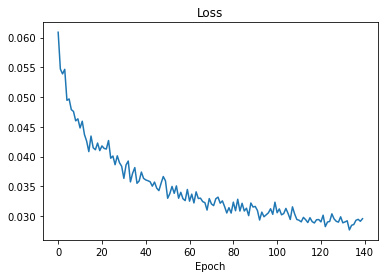

In [62]:
plt.figure()
plt.plot(train_losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [63]:
best_model_path = os.path.join('./model_params', 'DDPM.pth.tar')
best_model_state = torch.load(best_model_path)['network_params']

pipeline.model.load_state_dict(best_model_state)

<All keys matched successfully>

generating samples...


0it [00:00, ?it/s]

t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is

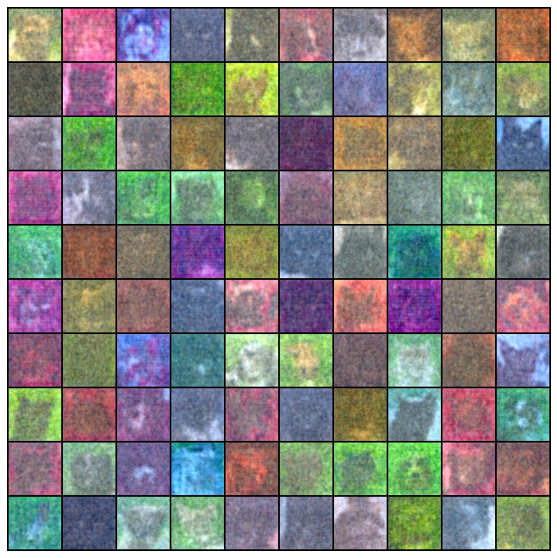

In [64]:
print('generating samples...')
n = 100
# import cv2
x = torch.randn(n, 3, *image_size).to(device)
generated_images = diffusion_utils.sample(x, pipeline.model)
generated_images = generated_images.cpu()
#normalize to within range (0, 1) from range (-1, 1)
generated_images = (generated_images.clamp(-1, 1) + 1) / 2

# fig, axs = plt.subplots(1, n, figsize=(10, 10))
# for i in range(n):
#     img = generated_images[i].permute(1, 2, 0) * 255
#     img = img.type(torch.uint8)
#     print('img_'+str(i)+'.png', img.dtype)
#     cv2.imwrite('img_'+str(i)+'.png', img.numpy())
#     axs[i].imshow(img)
# plt.show()
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_images.to(device),nrow=10, normalize=True).cpu(),(1,2,0)))
plt.show()

generating samples...


0it [00:00, ?it/s]

t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is

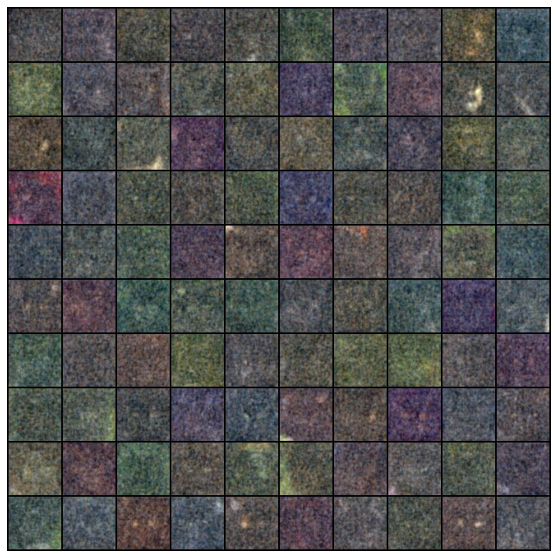

In [65]:
print('generating samples...')
n = 100
# diffusion_utils = DiffusionUtils(n_timesteps, beta_min, beta_max, device, scheduler=beta_scheduler)
x = torch.randn(n, 3, *image_size).to(device)
generated_images_1 = diffusion_utils.sample(x, pipeline.model, 300)
generated_images_1 = generated_images_1.cpu()
#normalize to within range (0, 1) from range (-1, 1)
generated_images_1 = (generated_images_1.clamp(-1, 1) + 1) / 2

# fig, axs = plt.subplots(1, n, figsize=(10, 10))
# for i in range(n):
#     img = generated_images[i].permute(1, 2, 0) * 255
#     img = img.type(torch.uint8)
#     axs[i].imshow(img)
# plt.show()

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_images_1.to(device),nrow=10, normalize=True).cpu(),(1,2,0)))
plt.show()

generating samples...


0it [00:00, ?it/s]

t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is  torch.Size([100])
t shape is

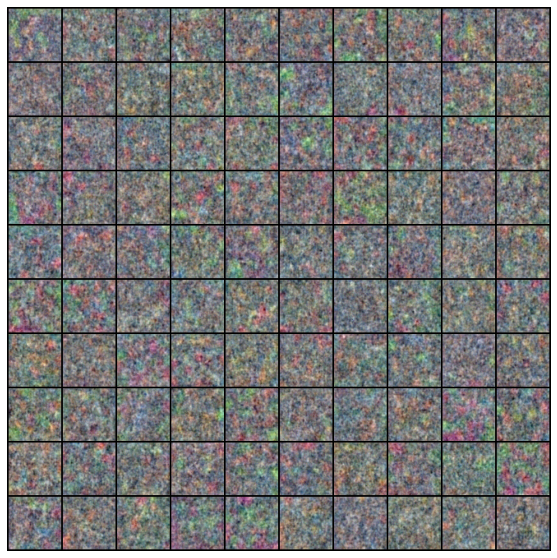

In [66]:
print('generating samples...')
n = 100

x = torch.randn(n, 3, *image_size).to(device)
generated_images_2 = diffusion_utils.sample(x, pipeline.model, 100)
generated_images_2 = generated_images_2.cpu()
#normalize to within range (0, 1) from range (-1, 1)
generated_images_2 = (generated_images_2.clamp(-1, 1) + 1) / 2

# fig, axs = plt.subplots(1, n, figsize=(10, 10))
# for i in range(n):
#     img = generated_images[i].permute(1, 2, 0) * 255
#     img = img.type(torch.uint8)

#     axs[i].imshow(img)
#     # break
# plt.show()

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_images_2.to(device),nrow=10, normalize=True).cpu(),(1,2,0)))
plt.show()
